In [4]:
import requests
from bs4 import BeautifulSoup
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
#import instaloader
from datetime import datetime
import pandas as pd
#import tweepy

In [ ]:
url1 = "https://www.bellanaijastyle.com/imad-eduso-lagos-fw-2024/"

response1 = requests.get(url1)
soup1 = BeautifulSoup(response1.content, 'html.parser')

images1 = []
for img1 in soup1.find_all('img1'):
    src = img1.get('src')
    if src and 'imad' in src:
        images1.append(src)
print(f"Found {len(images1)} images from Imad Eduso collection.")

In [ ]:
os.makedirs('imad_eduso_images', exist_ok=True)

for i, img_url in enumerate(images1):
    img_data = requests.get(img_url).content
    with open(os.path.join('imad_eduso_images', f'imad_eduso_{i+1}.jpg'), 'wb') as f:
        f.write(img_data)

In [ ]:
desc = []
for p in soup1.find_all('p', class_='description'):
    text = p.get_text(strip=True)
    if 'Imad Eduso' in text:
        desc.append(text)
    
print(desc[:10])

In [ ]:
os.makedirs('imad_eduso_images', exist_ok=True)

for i, img_url in enumerate(images1):
    img_data = requests.get(img_url).content
    with open(os.path.join('imad_eduso_images', f'imad_eduso_{i+1}.jpg'), 'wb') as f:
        f.write(img_data)

        
driver = webdriver.Chrome()
driver.get(url1)

time.sleep(15)
elements = driver.find_elements(By.TAG_NAME, 'img')
print(f"Found {len(elements)} image elements.")

for index, img in enumerate(elements):
    src = img.get_attribute('src')
    if src and src.startswith("http"):
        try:
            img_data = requests.get(src).content
            with open((f'imad_eduso_images/imad_eduso_images{index+1}.jpg'), 'wb') as f:
                f.write(img_data)
        except Exception as e:
            continue

driver.quit()
print("Image download completed.")

In [2]:
url_dict ={
    "bellanaija": ["https://www.bellanaijastyle.com/imad-eduso-lagos-fw-2024/"],
    "fashionandco": ["https://www.fashionandco.ng/imad-eduso-lagos-fashion-week-2024/"]    
    }

#os.makedirs('imad_eduso_images', exist_ok=True)

In [3]:
driver = webdriver.Chrome()

for web_page, urls in url_dict.items():
    folder = os.path.join('imad_eduso_images', web_page)
    if os.path.exists(folder):
        continue
    os.makedirs(folder, exist_ok=True)

    for url in urls:
        driver.get(url)
        time.sleep(15)

        elements = driver.find_elements(By.TAG_NAME, 'img')
        print(f"Found {len(elements)} image elements.")

        count = 0
        for index, img in enumerate(elements):
            src = img.get_attribute('src')
            if src and src.startswith("http"):
                try:
                    img_data = requests.get(src).content
                    filename = f"{'Imad_Eduso'}_{web_page}_{index+1}.jpg"
                    path = os.path.join(folder, filename)
                    with open((path), 'wb') as f:
                        f.write(img_data)
                except Exception as e:
                    print(f"Error downloading image {src}: {e}")
                    continue
        

driver.quit()
print("All Images from all websites downloaded.")

All Images from all websites downloaded.


In [4]:
import cv2
import numpy as np

dataset_dict = {"imad_eduso_images": ["bellanaija", "fashionandco"]}

processed_pics = {}

for imad_eduso, folders in dataset_dict.items():
    eduso_img = []

    for folder in folders:
        folder_dir = os.path.join('imad_eduso_images', folder)
        new_dir = os.path.join(folder_dir, "processed")
        os.makedirs(new_dir, exist_ok = True)
        
        for img_name in os.listdir(folder_dir):
            img_path = os.path.join(folder_dir, img_name)
           
            if not img_name.lower().endswith(('.jpg','.jpeg', '.png')):
                continue
            
            if "processed" in img_path:
                continue

            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224,224))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_norm = img / 255.0
                    eduso_img.append(img_norm)
                    cv2.imwrite(os.path.join(new_dir, img_name), cv2.cvtColor((img_norm * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue
    processed_pics[imad_eduso] = np.array(eduso_img)
    print(f"Processed {len(eduso_img)} images for {imad_eduso}.\n")

print("All brands have been preprocessed!")

Processed 31 images for imad_eduso_images.

All brands have been preprocessed!


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

mini_CNN = VGG16(weights='imagenet', include_top=False, pooling='avg')

imgen = ImageDataGenerator(rescale=1./255)
gen = imgen.flow_from_directory('imad_eduso_images', target_size=(224,224), batch_size=32, class_mode=None, shuffle=False)

features = mini_CNN.predict(gen)

filenames = gen.filenames
np.save('imad_eduso_features.npy', features)
np.save('imad_eduso_files.npy', filenames)

Found 62 images belonging to 2 classes.


c:\Users\User\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\fw_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


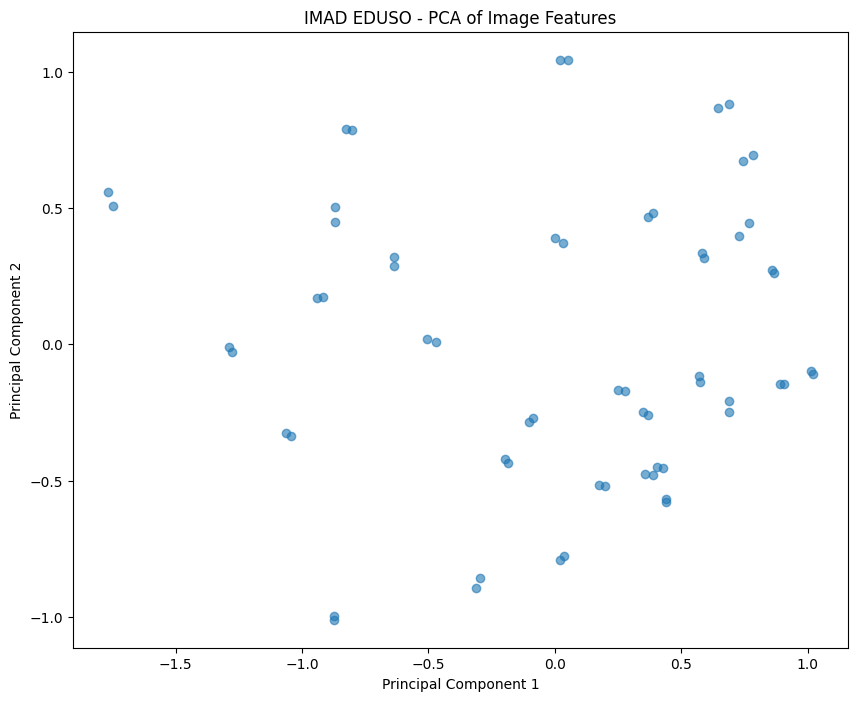

In [2]:
X = np.load('imad_eduso_features.npy')
y = np.load('imad_eduso_files.npy')

pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(pca_results[:,0], pca_results[:,1], alpha=0.6)
plt.title('IMAD EDUSO - PCA of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [10]:
def extract_colors(image_path, n_colors=5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    # Reshape pixels for clustering
    pixels = img.reshape(-1, 3)
    
    # Use KMeans to find dominant colors
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    
    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)
    
    # Sort by frequency
    sorted_colors = colors[np.argsort(-counts)]
    return sorted_colors


In [11]:
brand_colors = []

folder = 'imad_eduso_images/bellanaija/processed'
for img_name in os.listdir(folder):
    if img_name.endswith(('.jpg','.png')):
        img_path = os.path.join(folder, img_name)
        colors = extract_colors(img_path, n_colors=3)
        brand_colors.extend(colors)

# Convert to NumPy array
brand_colors = np.array(brand_colors)


In [12]:
# Optional: cluster all colors across images to find overall dominant colors
from sklearn.cluster import KMeans


kmeans_all = KMeans(n_clusters=5)
kmeans_all.fit(brand_colors)
common_colors = kmeans_all.cluster_centers_.astype(int)

print("Most common colors for brand:", common_colors)


Most common colors for brand: [[194  43 122]
 [222 222 231]
 [ 57  52  62]
 [168  58 112]
 [202 204 228]]


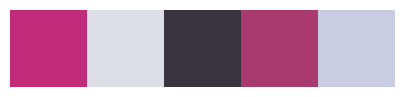

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,1))
plt.imshow([common_colors])
plt.axis('off')
plt.show()


In [ ]:
IG =instaloader.Instaloader()

IG.load_session_from_file("dijalaanita")

profile = instaloader.Profile.from_username(IG.context, "imadeduso_")

start_date = datetime(2024, 10, 1)
end_date = datetime(2024, 10, 31, 23, 59, 59)

posts = []

for post in profile.get_posts():
    post_date = post.date_utc
    if start_date <= post_date <= end_date:
        print(f"getting posts from {post_date}...")
        captions = post.caption or ""
        imad_insta_url = post.url

        posts.append({
            "date": post_date.strftime("%Y-%m-%d"),
            "caption": captions,
            "url": imad_insta_url
        })
        print("Collected posts")

    time.sleep(2)
print(f"Total posts collected: {len(posts)}")

imad_df = pd.DataFrame(posts)
output_file = f"{'imadeduso_'}_posts_october_2024.csv"
imad_df.to_csv(output_file, index=False, encoding='utf-8')
print(f"Data saved to {output_file}")

In [ ]:
api_key = "FgYB0fGNXJY8XdF3SmjtZVE8z"
api_secret = "kRsZzEj0e8gxquFiVJZ6dxKiaGouBLyl7ARgfCLVQhUtmQylcv"
access_token = "1950209199134171136-c8o8KDdZTK3Qho95wbJj4oJw9RxNFm"
access_secret = "7CCCWnYhCgAaNprSAcu5T9EtZHFpPIRI9pzeUHGe9ZcbA"

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

tweets = api.search_tweets(q="Imad Eduso", lang="en", since="2024-10-01", until="2024-10-31", count=100)
for tweet in tweets:
    print(f"{tweet.user.screen_name}: {tweet.text}\n")

In [ ]:
bearer_token = "AAAAAAAAAAAAAAAAAAAAAPsY5AEAAAAAIdhqY%2BHpZq4XBnxOk%2Bg6p5hDKH4%3DsjSdeFDBCzCwthLOyxD049nGXOAUot8VGMa7uSZr3lsf7iKLNr"

client = tweepy.Client(bearer_token=bearer_token)

query = "Imad Eduso -is:retweet lang:en"
start_date = "2024-10-01T00:00:00Z"
end_date = "2024-10-31T23:59:59Z"

tweets = client.search_recent_tweets(query=query, start_time=start_date, end_time=end_date, max_results=40, tweet_fields=['created_at', 'text', 'public_metrics', 'author_id'])

if tweets.data:
    for tweet in tweets.data:
        print(f"Created at: {tweet.created_at}")
        print(f"Text: {tweet.text}")
        print("\n")
else:
    print("No tweets found for the given query and date range.")